In [18]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from snowflake.snowpark import Session
import darts
import json
import shutil
from sklearn import preprocessing as pp, linear_model as lm, ensemble as ens, metrics as mt
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# from torch.utils.tensorboard import SummaryWriter
# from darts import TimeSeries
# from darts.dataprocessing.transformers import Scaler
# from darts.models import TransformerModel, TFTModel, ExponentialSmoothing
# from darts.metrics import mape
# from darts.utils.statistics import check_seasonality, plot_acf
# from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
credentials = json.load(open('secrets.json'))["SNOWFLAKE_CONNECTION"]
session = Session.builder.configs(credentials).create()
session.use_database("hackathon")
session.use_schema("public")
mdf = session.table("challenge1_train_data")
mdf = mdf.to_pandas()
mdf.columns = mdf.columns.str.lower()
mdf["date"] = pd.to_datetime(mdf["date"])
mdf.head()

,date,dc_name,size_code,retail_price,total_tires,zip_code
0,2022-02-05,OAKLAND,1856015,70.090,1,94604
1,2021-03-02,OAKLAND,1856015,59.090,1,94604
2,2020-12-08,OAKLAND,1856015,53.545,1,94604
3,2022-01-17,OAKLAND,1856015,58.410,1,94604
4,2020-11-13,OAKLAND,1856015,43.085,1,94604


In [10]:
mdf["month"] = mdf["date"].dt.month
mdf["year"] = mdf["date"].dt.year
mdf["quarter"] = mdf["date"].dt.quarter
mdf["weekday"] = mdf["date"].dt.weekday
mdf["since_2020"] = (mdf["date"] - pd.to_datetime("2020-01-01")).dt.total_seconds()
mdf

,date,dc_name,size_code,retail_price,total_tires,zip_code,month,year,quarter,weekday,since_2020
0,2022-02-05,OAKLAND,1856015,70.090,1,94604,2,2022,1,5,66182400.0
1,2021-03-02,OAKLAND,1856015,59.090,1,94604,3,2021,1,1,36806400.0
2,2020-12-08,OAKLAND,1856015,53.545,1,94604,12,2020,4,1,29548800.0
3,2022-01-17,OAKLAND,1856015,58.410,1,94604,1,2022,1,0,64540800.0
4,2020-11-13,OAKLAND,1856015,43.085,1,94604,11,2020,4,4,27388800.0
...,...,...,...,...,...,...,...,...,...,...,...
284695,2022-07-24,BAKERSFIELD,3512520,0.000,0,93308,7,2022,3,6,80784000.0
284696,2020-11-22,BAKERSFIELD,3512520,0.000,0,93308,11,2020,4,6,28166400.0
284697,2021-08-08,BAKERSFIELD,3512520,0.000,0,93308,8,2021,3,6,50544000.0
284698,2022-02-14,BAKERSFIELD,3512520,0.000,0,93308,2,2022,1,0,66960000.0


In [11]:
dfs = {name: frame for name, frame in mdf.groupby(["dc_name", "size_code"])}
dfs

{('BAKERSFIELD',
  1856015):              date      dc_name  size_code  retail_price  total_tires  \
 173740 2021-04-07  BAKERSFIELD    1856015        77.240            1   
 173741 2021-04-10  BAKERSFIELD    1856015        55.090            1   
 173742 2022-01-28  BAKERSFIELD    1856015         6.455            1   
 173743 2022-01-18  BAKERSFIELD    1856015        91.090            1   
 173744 2021-02-19  BAKERSFIELD    1856015        56.045            1   
 ...           ...          ...        ...           ...          ...   
 271160 2022-09-06  BAKERSFIELD    1856015         0.000            0   
 271161 2021-08-15  BAKERSFIELD    1856015         0.000            0   
 271162 2021-09-06  BAKERSFIELD    1856015         0.000            0   
 271163 2020-11-08  BAKERSFIELD    1856015         0.000            0   
 271164 2021-01-01  BAKERSFIELD    1856015         0.000            0   
 
         zip_code  month  year  quarter  weekday  since_2020  
 173740     93308      4  2021 

<AxesSubplot:xlabel='date'>

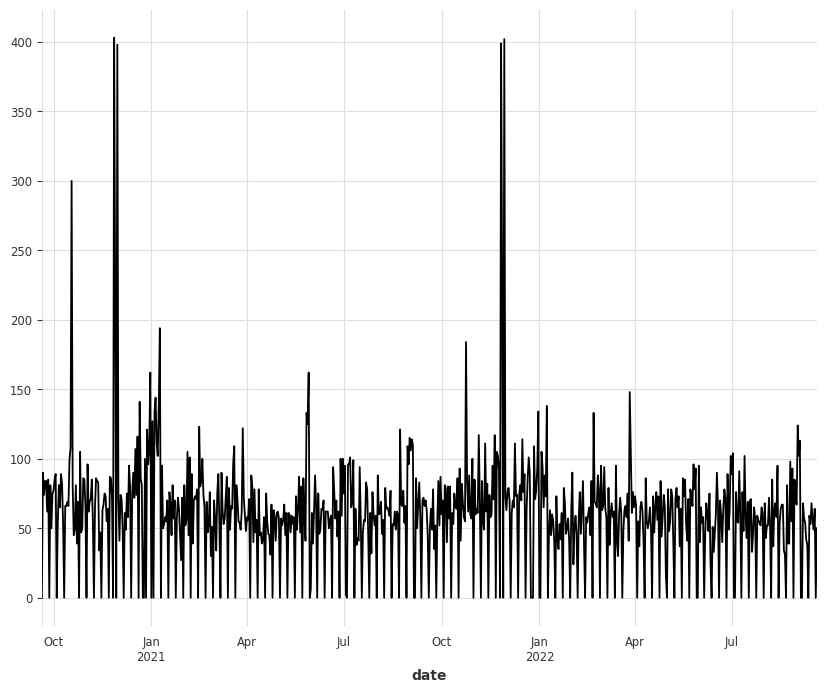

In [12]:
df = dfs[('BAKERSFIELD', 2155517)]
df.groupby("date")["total_tires"].sum().plot.line(figsize=(10, 8))

In [15]:
train_mask = df.date < "2022-07-01"
X_train= df.drop(columns="total_tires").loc[train_mask].copy()
y_train = df.loc[train_mask, "total_tires"].copy()
X_test = df.drop(columns="total_tires").loc[~train_mask].copy()
y_test = df.loc[~train_mask, "total_tires"].copy()
X_train, y_train

(             date      dc_name  size_code  retail_price  zip_code  month  \
 184631 2021-07-03  BAKERSFIELD    2155517       108.775     93308      7   
 184632 2021-05-31  BAKERSFIELD    2155517       156.455     93308      5   
 184633 2022-04-30  BAKERSFIELD    2155517       117.510     93308      4   
 184634 2022-02-02  BAKERSFIELD    2155517        85.290     93308      2   
 184635 2022-06-11  BAKERSFIELD    2155517       126.410     93308      6   
 ...           ...          ...        ...           ...       ...    ...   
 273393 2022-02-27  BAKERSFIELD    2155517         0.000     93308      2   
 273395 2020-12-20  BAKERSFIELD    2155517         0.000     93308     12   
 273396 2021-10-17  BAKERSFIELD    2155517         0.000     93308     10   
 273397 2021-12-25  BAKERSFIELD    2155517         0.000     93308     12   
 273398 2022-06-19  BAKERSFIELD    2155517         0.000     93308      6   
 
         year  quarter  weekday  since_2020  
 184631  2021        3      

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


ct = ColumnTransformer([("cat", pp.OneHotEncoder(handle_unknown="ignore"), ["month", "quarter", "weekday"]),
                       ("num", pp.MinMaxScaler(), ["retail_price", "year", "since_2020"])])
reg = Pipeline([
    ("ct", ct),
    ("reg", lm.RidgeCV(scoring="r2"))
])
reg.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'quarter',
                                                   'weekday']),
                                                 ('num', MinMaxScaler(),
                                                  ['retail_price', 'year',
                                                   'since_2020'])])),
                ('reg', RidgeCV(scoring='r2'))])

In [19]:
mt.r2_score(y_test, reg.predict(X_test))

0.5233384605829459

In [ ]:
model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
def simple_wape(y_true, y_pred):
    """Calculates simple wape"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.round(
        abs(y_true - y_pred).sum() / abs(y_true).sum()
        if abs(y_true).sum() != 0
        else np.inf,
        5,
    )

In [ ]:
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    cut = min(len(pred_series), len(val_series))
    pred_series = pred_series[:cut]
    val_series = val_series[:cut]
    wape = simple_wape(pred_series.univariate_values(), val_series.univariate_values())
    print(wape)
    plt.title("WAPE: {:.2f}%".format(wape * 100))
    plt.legend()
    
eval_model(model, 19, series_scaled, val_scaled)

In [ ]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="tire_transformer", best=True
)
eval_model(best_model, 19, series_scaled, val_scaled)